In [5]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
font = { 'size'   : 12}
matplotlib.rc('font', **font)
inputs = 'Data//'
outputs = 'Figures//' 

In [11]:
def simple_exp_smooth(d, extra_periods=1, alpha=0.4):
   
    # Historical period length
    cols = len(d) 
    # Append np.nan into the demand array to cover future periods
    d = np.append(d,[np.nan]*extra_periods) 
    
    # Forecast array
    f = np.full(cols+extra_periods,np.nan) 
    # Initilization of first forecast
    f[1] = d[0]
    
    # Create all the t+1 forecast until end of historical period
    for t in range(2,cols+1):
        f[t] = alpha*d[t-1]+(1-alpha)*f[t-1]
     
    # Forecast for all extra periods
    for t in range(cols+1,cols+extra_periods):
        # Update the forecast as the previous forecast
        f[t] = f[t-1]
           
    df = pd.DataFrame.from_dict({'Demand':d,'Forecast':f,'Error':d-f})
  
    return df

In [12]:
def double_exp_smooth(d, extra_periods=1, alpha=0.4, beta=0.4):
    
    # Historical period length
    cols = len(d) 
    # Append np.nan into the demand array to cover future periods
    d = np.append(d,[np.nan]*extra_periods) 
    
    # Creation of the level, trend and forecast arrays
    f,a,b = np.full((3,cols+extra_periods),np.nan)
    
    # Level & Trend initialization
    a[0] = d[0]
    b[0] = d[1] - d[0]
 
    # Create all the t+1 forecast
    for t in range(1,cols):
        f[t] = a[t-1] + b[t-1]       
        a[t] = alpha*d[t] + (1-alpha)*(a[t-1]+b[t-1])       
        b[t] = beta*(a[t]-a[t-1]) + (1-beta)*b[t-1]
        
    # Forecast for all extra periods
    for t in range(cols,cols+extra_periods):
        f[t] = a[t-1] + b[t-1]
        a[t] = f[t]
        b[t] = b[t-1]
                          
    df = pd.DataFrame.from_dict({'Demand':d,'Forecast':f,'Level':a,'Trend':b,'Error':d-f})
  
    return df

In [24]:
def exp_smooth_opti(d, extra_periods=6):
    params = []
    KPIs = []
    dfs = []

    for alpha in [0.05,0.1,0.2,0.3,0.4,0.5,0.6]:
        df = simple_exp_smooth(d,extra_periods=extra_periods,alpha=alpha)
        params.append(f'Simple Smoothing, alpha: {alpha}')
        dfs.append(df)
        MAE = df['Error'].abs().mean()
        KPIs.append(MAE)

        for beta in [0.05,0.1,0.2,0.3,0.4]:
            df = double_exp_smooth(d,extra_periods=extra_periods,alpha=alpha)
            params.append(f'Double Smoothing, alpha: {alpha}, beta:{beta}')
            dfs.append(df)
            MAE = df['Error'].abs().mean()
            KPIs.append(MAE)
        
    mini = np.argmin(KPIs)
    print(f'Best solution found for {params[mini]} MAE of', round(KPIs[mini],2))

    return dfs[mini]
        

In [25]:
d = [28,19,18,13,19,16,19,18,13,16,16,11,18,15,13,15,13,11,13,10,12]
df = exp_smooth_opti(d)


Best solution found for Simple Smoothing, alpha: 0.4 MAE of 2.74


<AxesSubplot:title={'center':'Best model found'}>

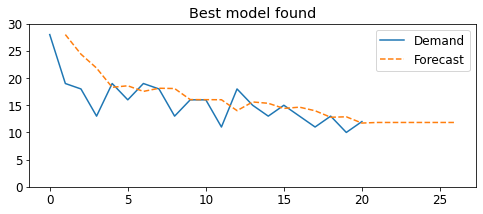

In [17]:
df[['Demand','Forecast']].plot(figsize=(8,3),title='Best model found',ylim=(0,30),style=['-','--'])